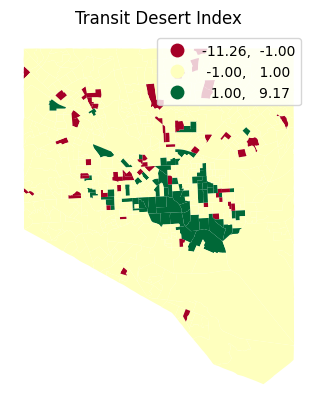

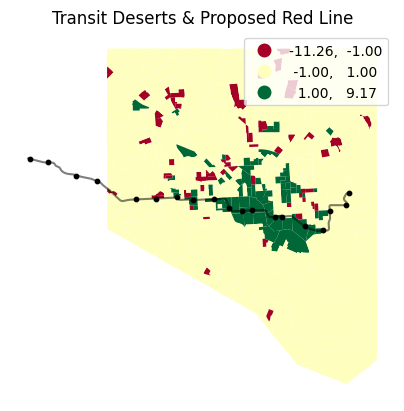

In [17]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
import mapclassify
import folium
#shapefile downloaded from: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2018.html#list-tab-790442341
#data downloaded from: https://www.arcgis.com/home/item.html?id=f1b6dd3c82d748ca9ac1e98972de5e5a

#create data frame with transit desert index data, add missing data, prepare dataframe for merge
transit_desert = pd.read_excel('TD_V1_BAL_cbg.xlsx')
transit_desert.rename(columns = {'GEOID10':'GEOID'}, inplace = True)
transit_desert['GEOID'] = transit_desert['GEOID'].apply(np.int64)
transit_desert.loc[transit_desert['GEOID'] == 245101307003, 'Gap_Zscore TD'] = -0.002674515
transit_desert.loc[transit_desert['GEOID'] == 245101304001, 'Gap_Zscore TD'] = 0.038632496
transit_desert.loc[transit_desert['GEOID'] == 245100401001, 'Gap_Zscore TD'] = 3.7691295

#create geodataframe from 2018 block group shapefile, narrow down to Baltimore City, merge
blocks_map2018 = gp.read_file('tl_2018_24_bg.shp')
blocks_map2018 = blocks_map2018.loc[blocks_map2018['COUNTYFP'] == '510']
blocks_map2018['GEOID'] = blocks_map2018['GEOID'].apply(np.int64)
TDI_map = blocks_map2018.merge(transit_desert, on = 'GEOID')

#create geodataframes of stations and alignment of proposed red line
stations = gp.read_file('Stations-point.shp')
alignment = gp.read_file('Alignment-line.shp')

#plot map of transit desert index
ax = TDI_map.plot(column='Gap_Zscore TD', cmap= 'RdYlGn', scheme='user_defined', classification_kwds={'bins':[-1, 1]}, legend= True)
ax.set_axis_off()
plt.title('Transit Desert Index')

#plot map of transit desert index and proposed red line
base = TDI_map.plot(column='Gap_Zscore TD', cmap= 'RdYlGn', scheme='user_defined', classification_kwds={'bins':[-1, 1]}, legend= True)
ax = alignment.plot(ax=base, marker='o', color='black', markersize=10, alpha= 0.5)
ax = stations.plot(ax=base, marker='o', color='black', markersize=10)
ax.set_axis_off()
plt.title('Transit Deserts & Proposed Red Line')

#plot explore map of transit desert index and proposed red line
tdi_explore_layers = TDI_map.explore(column='Gap_Zscore TD', cmap= 'RdYlGn', scheme='user_defined', classification_kwds={'bins':[-1, 1]}, legend= True, name='Base')
tdi_explore_layers = stations.explore(m=tdi_explore_layers, color='black', name='Points')
tdi_explore_layers = alignment.explore(m=tdi_explore_layers, color='black', name='lines')
tdi_explore_layers

Text(0.5, 1.0, 'Population by Block Group')

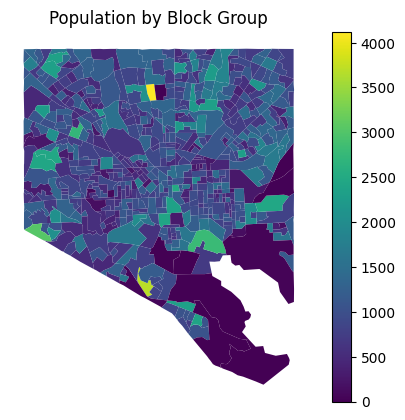

In [18]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
#data downloaded from: https://data.census.gov/table?t=Population+Total&g=050XX00US24510$1500000&tid=ACSDT5Y2021.B01003&moe=false
#"B01003", 2021: ACS 5-Year Estimates Detailed Tables
#shapefile downloaded from: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2021.html#list-tab-790442341

#create data frame with 2021 ACS population count data and transpose
population2021 = pd.read_csv('PopulationCountCensus.csv', thousands= ',')
population2021 = population2021.transpose()
population2021 = population2021.reset_index()
population2021 = population2021.drop(labels=0, axis=0)
population2021.rename(columns = {0:'Total Population'}, inplace = True)
population2021['Total Population'] = population2021['Total Population'].astype(np.int64)

#to create a GEOID column, split the census data labels and create a new dataframe
geoid_population = population2021['index'].str.split(expand=True)
geoid_population['Block Group Number'] = geoid_population[2].str.replace('\W', '', regex=True)
#to fill in zeroes in tract section of GEOID, create a new dataframe
geoid_tracts_population = geoid_population[5].str.split(pat='.', expand=True)
geoid_tracts_population = geoid_tracts_population.replace('\W','', regex = True)
#first four digits
geoid_tracts_population[0] = geoid_tracts_population[0].str.pad(width=4, side='left', fillchar='0')
#last two digits
geoid_tracts_population[1] = geoid_tracts_population[1].fillna('0')
geoid_tracts_population[1] = geoid_tracts_population[1].str.pad(width=2, side='left', fillchar='0')
#concatenate state, county, tract, and block group codes (24510 = state and county code for Baltimore City, Maryland)
population2021['GEOID'] = '24510' + geoid_tracts_population[0] + geoid_tracts_population[1] + geoid_population['Block Group Number']
population2021['GEOID'] = population2021['GEOID'].astype('Int64')

#create geodataframe from 2021 block group shapefile, narrow down to Baltimore City, merge
blockgroup2021 = gp.read_file('cb_2021_24_bg_500k.shp')
blockgroup2021 = blockgroup2021.loc[blockgroup2021["COUNTYFP"] == "510"]
blockgroup2021['GEOID'] = blockgroup2021['GEOID'].astype('Int64')
population2021_map = blockgroup2021.merge(population2021, on='GEOID')

#plot map of population
ax = population2021_map.plot(column='Total Population', legend = True, missing_kwds={'color':'lightgrey'})
ax.set_axis_off()
plt.title('Population by Block Group')

Text(0.5, 1.0, "Median Household Income Compared to 80% of Baltimore's")

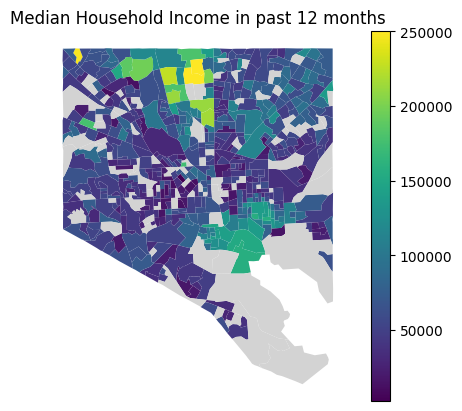

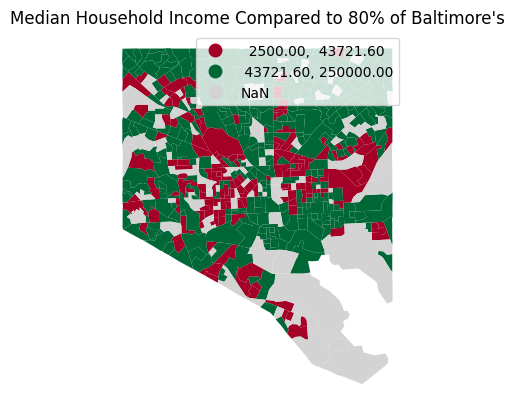

In [19]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
import mapclassify
#https://data.census.gov/map?t=Income+and+Poverty&g=050XX00US24510$1500000&tid=ACSDT5Y2021.B19013&layer=VT_2021_150_00_PY_D1&mode=thematic&loc=39.2848,-76.6401,z10.4855
#"B19013", 2021: ACS 5-Year Estimates Detailed Tables
#shapefile downloaded from: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2021.html#list-tab-790442341
#Baltimore median household income from https://data.census.gov/profile/Baltimore_city,_Maryland?g=160XX00US2404000

#create data frame with 2021 ACS median household income data and transpose
median_house_income21 = pd.read_csv('ACSDT5Y2021.B19013-2023-08-04T162824.csv', thousands= ',')
median_house_income21 = median_house_income21.transpose()
median_house_income21 = median_house_income21.reset_index()
median_house_income21 = median_house_income21.drop(labels=0, axis=0)
#replacing non-standard values 
median_house_income21.replace('250,000+','250000', inplace=True)
median_house_income21.replace('2,500-','2500', inplace=True)
median_house_income21.replace('-',np.nan, inplace=True)
median_house_income21.rename(columns = {0:'Median Household Income'}, inplace = True)
median_house_income21['Median Household Income'] = median_house_income21['Median Household Income'].astype(float)

#to create a GEOID column, split the census data labels and create a new dataframe
geoid_medhouseinc = median_house_income21['index'].str.split(expand=True)
geoid_medhouseinc['Block Group Number'] = geoid_medhouseinc[2].str.replace('\W', '', regex=True)
#to fill in zeroes in tract section of GEOID, create a new dataframe
geoid_tracts_medhouseinc = geoid_medhouseinc[5].str.split(pat='.', expand=True)
geoid_tracts_medhouseinc = geoid_tracts_medhouseinc.replace('\W','', regex = True)
#first four digits
geoid_tracts_medhouseinc[0] = geoid_tracts_medhouseinc[0].str.pad(width=4, side='left', fillchar='0')
#last two digits
geoid_tracts_medhouseinc[1] = geoid_tracts_medhouseinc[1].fillna('0')
geoid_tracts_medhouseinc[1] = geoid_tracts_medhouseinc[1].str.pad(width=2, side='left', fillchar='0')
#concatenate state, county, tract, and block group codes (24510 = state and county code for Baltimore City, Maryland)
median_house_income21['GEOID'] = '24510' + geoid_tracts_medhouseinc[0] + geoid_tracts_medhouseinc[1] + geoid_medhouseinc['Block Group Number']
median_house_income21['GEOID'] = median_house_income21['GEOID'].astype('Int64')

#calculating 80% of Baltimore's median household income
baltimore_median80 = 54652*.8

#create geodataframe from 2021 block group shapefile, narrow down to Baltimore City, merge
blockgroup2021 = gp.read_file('cb_2021_24_bg_500k.shp')
blockgroup2021 = blockgroup2021.loc[blockgroup2021['COUNTYFP'] == '510']
blockgroup2021['GEOID'] = blockgroup2021['GEOID'].astype('Int64')
median_house_map = blockgroup2021.merge(median_house_income21, on='GEOID')

#plot map of median household income
ax = median_house_map.plot(column='Median Household Income', legend = True, missing_kwds={'color':'lightgrey'})
ax.set_axis_off()
plt.title('Median Household Income in past 12 months')

#plot map of median household income above and below 80% of city-wide median household income
ax = median_house_map.plot(column='Median Household Income', cmap= 'RdYlGn', scheme='user_defined', classification_kwds={'bins':[baltimore_median80]}, legend = True, missing_kwds={'color':'lightgrey'})
ax.set_axis_off()
plt.title('Median Household Income Compared to 80% of Baltimore\'s')

Text(0.5, 1.0, '30% or More of Households do not Have Vehicles (pink)')

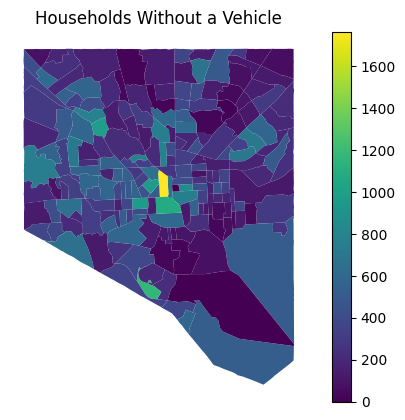

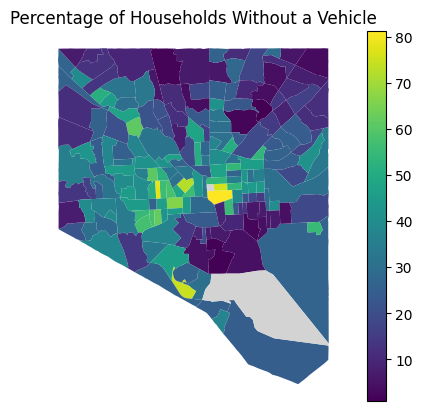

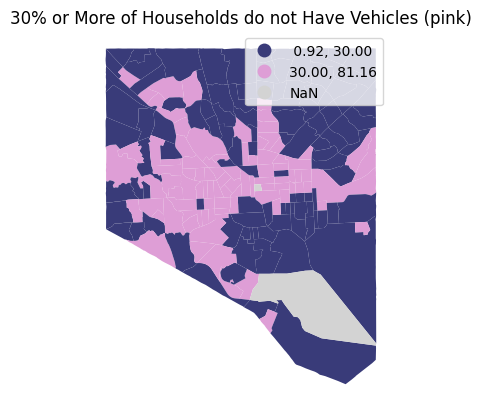

In [20]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
#data downloaded from: https://data.census.gov/table?q=Transportation&g=050XX00US24510$1400000&tid=ACSDT5Y2021.B08141&moe=false
#"B08203", 2021: ACS 5-Year Estimates Detailed Tables
#shapefile downloaded from: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2021.html#list-tab-790442341
#Note: this data is available only at the census tract level for Baltimore

#create data frame with number of vehicles by number of workers in household data and transpose
vehicle_house21 = pd.read_csv('ACSDT5Y2021.B08203-2023-08-07T214015.csv', thousands= ',')
vehicle_house21 = vehicle_house21.transpose()
vehicle_house21 = vehicle_house21.reset_index()
vehicle_house21 = vehicle_house21.drop(labels=0, axis=0)
#replacing non-standard values 
vehicle_house21.replace('-',np.nan, inplace=True)
vehicle_house21.rename(columns = {0:'Total Households'}, inplace = True)
vehicle_house21.rename(columns = {1:'No Vehicle'}, inplace = True)
vehicle_house21['Total Households'] = vehicle_house21['Total Households'].astype(float)
vehicle_house21['No Vehicle'] = vehicle_house21['No Vehicle'].astype(float)

#calculate the percentage of the total population in poverty
vehicle_house21['Percent'] = vehicle_house21['No Vehicle']/vehicle_house21['Total Households']*100

#to create a GEOID column, split the census data labels and create a new dataframe
geoid_vehicle = vehicle_house21['index'].str.split(expand=True)
geoid_vehicle = geoid_vehicle[2].str.split(pat='.', expand=True)
geoid_vehicle = geoid_vehicle.replace('\W','', regex = True)
#fill in first four digits of tract number
geoid_vehicle[0] = geoid_vehicle[0].str.pad(width=4, side='left', fillchar='0')
#fill in last two digits of tract number
geoid_vehicle[1] = geoid_vehicle[1].fillna('0')
geoid_vehicle[1] = geoid_vehicle[1].str.pad(width=2, side='left', fillchar='0')
#concatenate state, county, and tract codes(24510 = state and county code for Baltimore City, Maryland)
vehicle_house21['GEOID'] = '24510' + geoid_vehicle[0] + geoid_vehicle[1]
vehicle_house21['GEOID'] = vehicle_house21['GEOID'].astype('Int64')

#create geodataframe from 2021 tract shapefile, narrow down to Baltimore City, merge
tract21 = gp.read_file('tl_2021_24_tract.shp')
tract21 = tract21.loc[tract21["COUNTYFP"] == "510"]
tract21['GEOID'] = tract21['GEOID'].astype('Int64')
vehicle_map = tract21.merge(vehicle_house21, on='GEOID')

#plot map of households without a vehicle
ax = vehicle_map.plot(column='No Vehicle', legend = True, missing_kwds={'color':'lightgrey'})
ax.set_axis_off()
plt.title('Households Without a Vehicle')

#plot map of percentage of households without a vehicle
ax = vehicle_map.plot(column='Percent', legend = True, missing_kwds={'color':'lightgrey'})
ax.set_axis_off()
plt.title('Percentage of Households Without a Vehicle')

#plot map of tracts where 30% or more of households do not have vehicles
ax = vehicle_map.plot(column='Percent', legend = True, scheme='user_defined', cmap= 'tab20b', classification_kwds={'bins':[30]}, missing_kwds={'color':'lightgrey'})
ax.set_axis_off()
plt.title('30% or More of Households do not Have Vehicles (pink)')

Text(0.5, 1.0, 'Areas w/ Poverty Percentage Levels 20% or Higher (pink)')

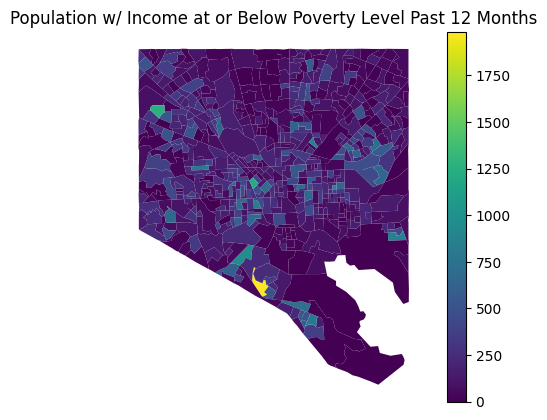

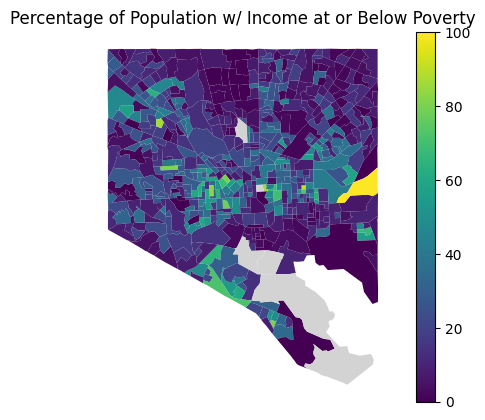

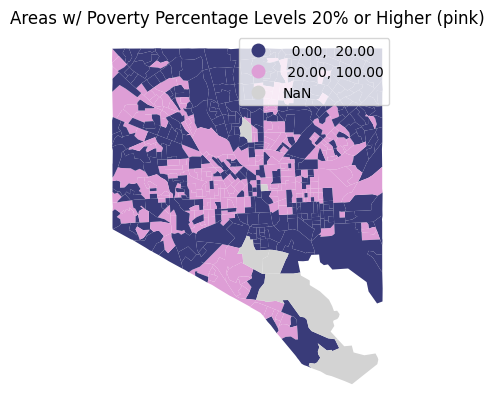

In [21]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp
import mapclassify
#data downloaded from: https://data.census.gov/map?t=Income+and+Poverty&g=050XX00US24510$1500000&tid=ACSDT5Y2021.B17101&layer=VT_2021_150_00_PY_D1&mode=thematic&loc=39.2848,-76.6401,z10.4855
#"B17101", 2021: ACS 5-Year Estimates Detailed Tables
#shapefile downloaded from: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.2021.html#list-tab-790442341

#create data frame with 2021 ACS poverty data and transpose
poverty21 = pd.read_csv('ACSDT5Y2021.B17101-2023-08-07T210028.csv', thousands= ',')
poverty21 = poverty21.transpose()
poverty21 = poverty21.reset_index()
poverty21 = poverty21.drop(labels=0, axis=0)
poverty21.rename(columns = {1:'Poverty'}, inplace = True)
poverty21.rename(columns = {0:'Total Population'}, inplace = True)
poverty21.replace('250,000+','250000', inplace=True)
poverty21.replace('2,500-','2500', inplace=True)
poverty21.replace('-',np.nan, inplace=True)
#replace non-standard values 
poverty21['Poverty'] = poverty21['Poverty'].astype(float)
poverty21['Total Population'] = poverty21['Total Population'].astype(float)

#calculate the percentage of the total population in poverty
poverty21['Percent'] = poverty21['Poverty']/poverty21['Total Population']*100

#to create a GEOID column, split the census data labels and create a new dataframe
geoid_poverty = poverty21['index'].str.split(expand=True)
geoid_poverty['Block Group Number'] = geoid_poverty[2].str.replace('\W', '', regex=True)
#to fill in zeroes in tract section of GEOID, create a new dataframe
geoid_tracts_poverty = geoid_poverty[5].str.split(pat='.', expand=True)
geoid_tracts_poverty = geoid_tracts_poverty.replace('\W','', regex = True)
#first four digits
geoid_tracts_poverty[0] = geoid_tracts_poverty[0].str.pad(width=4, side='left', fillchar='0')
#last two digits
geoid_tracts_poverty[1] = geoid_tracts_poverty[1].fillna('0')
geoid_tracts_poverty[1] = geoid_tracts_poverty[1].str.pad(width=2, side='left', fillchar='0')
#concatenate state, county, tract, and block group codes (24510 = state and county code for Baltimore City, Maryland)
poverty21['GEOID'] = '24510' + geoid_tracts_poverty[0] + geoid_tracts_poverty[1] + geoid_poverty['Block Group Number']
poverty21['GEOID'] = poverty21['GEOID'].astype('Int64')

#create geodataframe from 2021 block group shapefile, narrow down to Baltimore City, merge
blockgroup2021 = gp.read_file('cb_2021_24_bg_500k.shp')
blockgroup2021 = blockgroup2021.loc[blockgroup2021["COUNTYFP"] == "510"]
blockgroup2021['GEOID'] = blockgroup2021['GEOID'].astype('Int64')
poverty_map = blockgroup2021.merge(poverty21, on='GEOID')

#plot map of poverty 
ax = poverty_map.plot(column='Poverty', legend = True, missing_kwds={'color':'lightgrey'})
ax.set_axis_off()
plt.title('Population w/ Income at or Below Poverty Level Past 12 Months')

#plot map of poverty percentage
ax = poverty_map.plot(column='Percent', legend = True, missing_kwds={'color':'lightgrey'})
ax.set_axis_off()
plt.title('Percentage of Population w/ Income at or Below Poverty')

#plot map of block groups with poverty higher than 20% of population
ax = poverty_map.plot(column='Percent', cmap= 'tab20b', scheme='user_defined', classification_kwds={'bins':[20]}, legend = True, missing_kwds={'color':'lightgrey'})
ax.set_axis_off()
plt.title('Areas w/ Poverty Percentage Levels 20% or Higher (pink)')

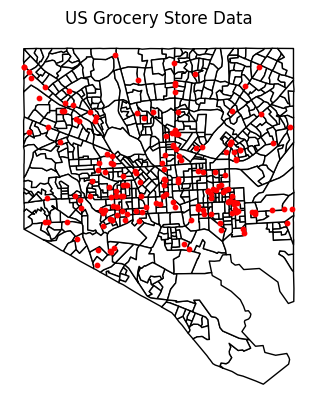

In [23]:
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import point
#download data from: https://auth.data-axle.com/signups/new?client_id=aa896f8ee71ef28c99a9b997&information_uri=https%3A%2F%2Fplatform.data-axle.com%2Fsignup_information
#Primary NAICS code for grocery stores (excluding convenience) is 445110

#create dataframe using DataAxle data for Baltimore, narrow down to Baltimore's City's county id code
food_retailers = pd.read_csv("BaltimoreFoodRetailers-00000_places.csv.gz")
food_retailers = food_retailers[food_retailers["fips_code"] == 24510]
food_map = gp.GeoDataFrame(
    food_retailers, geometry=gp.points_from_xy(food_retailers.longitude, food_retailers.latitude), crs="EPSG:4326"
)

#create geodataframe from 2021 block group shapefile, narrow down to Baltimore City
blockgroup2021 = gp.read_file('cb_2021_24_bg_500k.shp')
blockgroup2021 = blockgroup2021.loc[blockgroup2021["COUNTYFP"] == "510"]
blockgroup2021['GEOID'] = blockgroup2021['GEOID'].astype('Int64')

#plot grocery store location on Baltimore City block group map
base = blockgroup2021.plot(color='white', edgecolor='black')
food_map.plot(ax=base, marker='o', color='red', markersize=10)
base.set_axis_off()
plt.title('US Grocery Store Data')

#plot explore map
food_map.explore()